In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Modelling steps 3 and 4.
## Needs a network, clustered zones with volumes and level of service attributes.

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
# Create LoS table
sm.car_los = car.car_los
sm.los = sm.pt_los.append(sm.car_los)
sm.los.reset_index(drop=True, inplace=True)
print(len(sm.los))
sm.los.sample(3)

1544439


,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,price,route_type,route_types,time,waiting_time
545663,1489,0.374427,DEF08,2068.0,8280,394948,"[bus_233105, bus_533743, bus_533747, bus_32304...",11,DE932,None,9.101043,coach,"[bus, coach]",19037,7200.0
540791,592,0.000000,DE22B,155.0,7500,405164,"[bus_1651718, bus_1651719, rail_long_4448, rai...",3,DE732,None,60.051800,rail_long_distance,"[bus, rail_long_distance]",10647,2400.0
755624,592,0.221945,DEB36,1358.0,13740,737788,"[rail_short_30917, rail_short_30918, rail_shor...",5,DE804,None,275.761580,air,"[rail_short_distance, air]",21390,5700.0


In [5]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]

In [6]:
len(sm.los)

1521701

In [7]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [8]:
# Scale time to hours
sm.los['time'] = sm.los['time'] / 3600

In [9]:
# Create a column for non-linear time
#sm.los['time2'] = np.power(sm.los['time'], 2)

### Prepare the logit model

In [10]:
# Link route types are going to be the PT nest's modes
route_types = ['rail_long_distance', 'rail_short_distance',
               'coach', 'bus', 'air','car', 'walk']

In [11]:
# Trip purposes from transport demand input data
segments = ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']

In [12]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long_distance': 'PT', 'rail_short_distance': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''for s in segments:
    sm.los['gc_'+s] = sm.los['time'] + [c / vot[s, m_dict[m]][int(d/1000)]
        if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]'''

"for s in segments:\n    sm.los['gc_'+s] = sm.los['time'] + [c / vot[s, m_dict[m]][int(d/1000)]\n        if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]"

In [13]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results_splineGC_distVoT.xlsx')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))
#df = excel.parse(1) # NL for all purposes
#params_root = df.set_index(df.columns[0])

In [14]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['pt']*4 + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['pt', 'root'],
                     data={p: col for p in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,
rail_long_distance,pt,pt,pt,pt,pt
rail_short_distance,pt,pt,pt,pt,pt
coach,pt,pt,pt,pt,pt
bus,pt,pt,pt,pt,pt
air,root,root,root,root,root
car,root,root,root,root,root
walk,root,root,root,root,root
pt,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN


In [15]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for seg in segments]
sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
                             for i in range(len(segments))]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6
rail_long_distance,1.000000,1.000000,1.000000,1.000000,1.000000
rail_short_distance,1.000000,1.000000,1.000000,1.000000,1.000000
coach,1.000000,1.000000,1.000000,1.000000,1.000000
bus,1.000000,1.000000,1.000000,1.000000,1.000000
air,1.000000,1.000000,1.000000,1.000000,1.000000
car,1.000000,1.000000,1.000000,1.000000,1.000000
walk,1.000000,1.000000,1.000000,1.000000,1.000000
root,1.000000,1.000000,1.000000,1.000000,1.000000
pt,0.728639,0.651549,0.400078,0.175739,0.292786


In [16]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail_short_distance', 'asc_rail'),
               ('rail_long_distance', 'asc_rail'),
               ('coach', 'asc_coach'), ('bus', 'asc_bus'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6
rail_short_distance,-2.339213,0.082624,-3.171848,-2.829009,-2.870476
rail_long_distance,-2.339213,0.082624,-3.171848,-2.829009,-2.870476
coach,-5.855302,-1.807886,-6.114638,-3.338342,-3.514143
bus,-2.547341,0.785692,-3.027649,-2.845934,-2.757923
air,-11.780800,-8.268946,-8.070466,-3.030383,-5.199136
car,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-4.751766,-3.296622,-4.121024,-3.896484,-3.276113
root,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
# Performance attributes for mode choice
#perf_attrs = ['time', 'price', 'accessibility']
perf_attrs = ['gc_d', 'accessibility']
#perf_attrs = ['gc_d_'+s for s in segments] + ['accessibility']

In [18]:
# Beta parameters from calibration data
# IMPORTANT: conversion
sm.utility_values = pd.DataFrame({seg: [] for seg in segments})
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a, b in zip(perf_attrs, ['b_gc', 'b_ac']): # time betas in EUR/h
    sm.utility_values.loc[a] = [params_est[i].loc[b, 'Value']
                                for i in range(len(segments))]
'''for a, s in zip(perf_attrs[:-1], segments:
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values.loc['accessibility'] = [params_est[i].loc['b_ac', 'Value']
                                          for i in range(len(segments))]'''
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6
mode_utility,1.000000,1.000000,1.000000,1.000000,1.000000
gc_d,-0.528548,-0.540012,-0.373001,-0.034972,-0.057151
accessibility,0.962972,0.273572,0.890637,0.775304,0.664555


In [19]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=40, c2=80, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
#for s in segments:
#    sm.los['gc_d_'+s] = sm.los['gc_'+s].apply(spline)
sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [20]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,gc_d,accessibility,length
origin,destination,route_type,,,
DE731,DEB38,coach,7.914245,0.000000,272586
DEA19,DEF03,car,7.838499,0.613015,456621
DE40E,DE935,rail_short_distance,20.440433,0.000000,459733
DEB22,DE21D,air,13.326505,0.442609,769725
DEA36,DED43,air,9.373447,0.000000,972508


<AxesSubplot:xlabel='gc'>

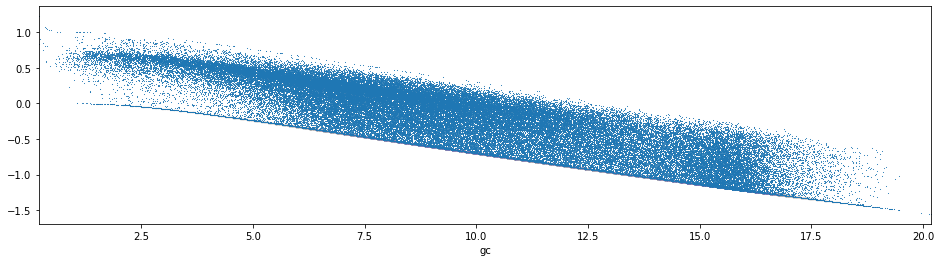

In [22]:
# Example utility decomposition
t = sm.los[perf_attrs + ['gc']].sample(int(len(sm.los)/10))
for s in segments:
    for a in perf_attrs:
        t['u_'+a] = t[a] * sm.utility_values.loc[a,s]
t['u'] = t['u_gc_d'] + t['accessibility']
t.set_index('gc')['u'].plot(figsize=(16,4), linestyle=' ', marker='x', markersize=.3)
#fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,4), sharex='all', sharey='row')#,
#                       xlabel='Generalised Cost in hours', ylabel='Utility')
#for s in segments:
#    t.set_index('gc'+s)['u_gc_d_'+s].plot(
#        label=s, legend=True, linestyle= ' ', marker='x', markersize=.3, ax=ax[segments.index(s)])

## Mode Choice

In [23]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
sm.analysis_mode_utility(how='max', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


In [24]:
# Create empty OD matrices for od_probabilities and od_utilities
#sm.initialize_logit()

In [25]:
# Run the logit model
sm.step_logit(workers=1, decimals=8, nchunks=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


In [26]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(774190, 12)
(774190, 12)


In [27]:
sm.probabilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short_distance,rail_long_distance
746655,DE213,DEF0C,Fz6,1,0.0,0.667948,0.261144,0.070908,0.0,0.000000,0.000000,0.070908
15455,DEG0I,DE273,Fz1,1,0.0,0.996942,0.000000,0.003058,0.0,0.003023,0.000036,0.000000
717520,DE279,DEB3C,Fz6,1,0.0,0.891100,0.000000,0.108900,0.0,0.101399,0.007500,0.000000
72628,DEA22,DEB3H,Fz1,1,0.0,0.970935,0.000000,0.029065,0.0,0.020166,0.000002,0.008897
651309,DE117,DE26C,Fz6,1,0.0,0.945192,0.000000,0.054808,0.0,0.051269,0.003539,0.000000


In [28]:
sm.utilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short_distance,rail_long_distance
365818,DE725,DED51,Fz3,-0.925594,-inf,-0.956427,-inf,-4.420150,-inf,-4.420167,-inf,-8.437677
238097,DE722,DED51,Fz2,-2.826240,-inf,-2.862959,-inf,-6.148990,-inf,-6.155087,-10.942976,-9.241968
650161,DEG0H,DE40F,Fz6,0.012041,-inf,-0.052722,-inf,-2.757193,-inf,-inf,-3.288310,-2.809288
339525,DEG09,DEG04,Fz3,0.394687,-inf,0.339271,-inf,-2.525784,-inf,-2.531983,-4.196112,-inf
363292,DE40G,DE71A,Fz3,-2.808597,-inf,-3.365057,-3.664492,-9.094493,-inf,-9.174169,-inf,-9.779275


### Save model

In [29]:
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:15<00:00,  2.60it/s]


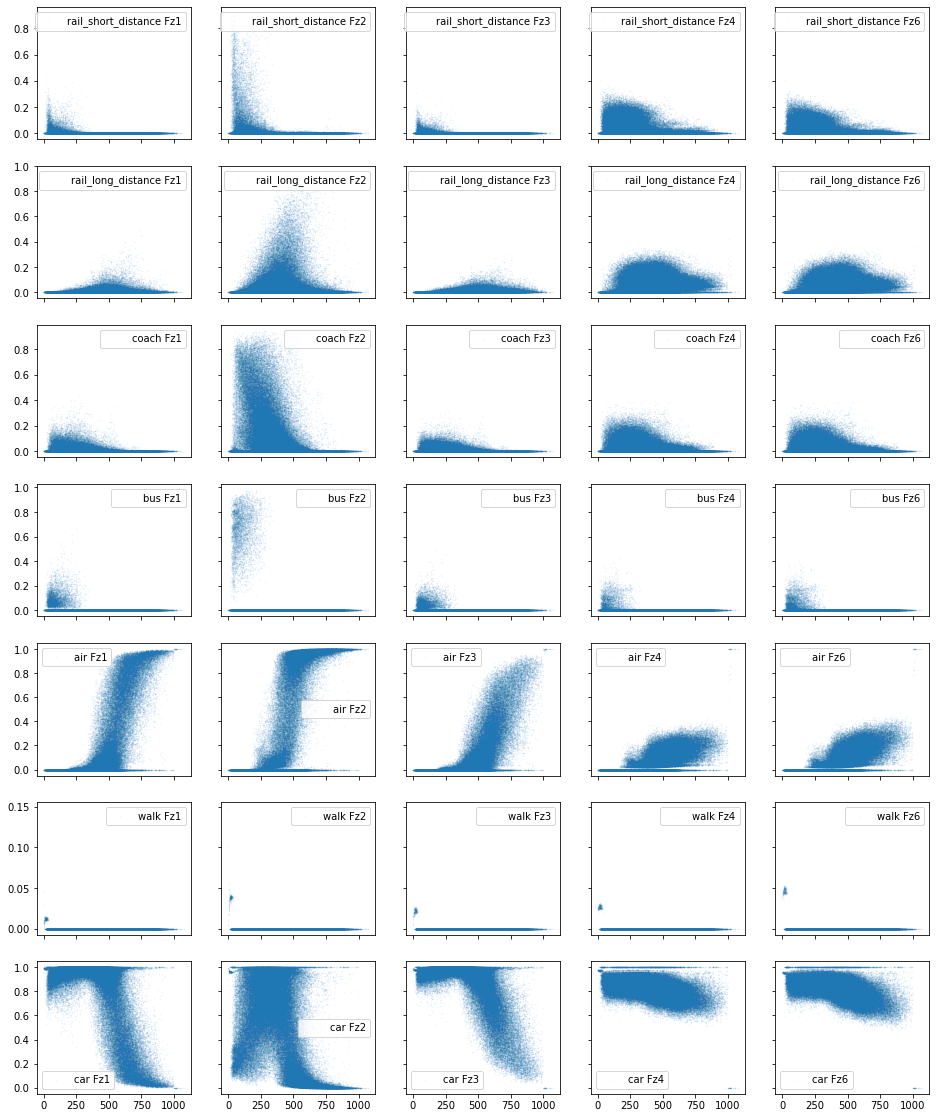

In [30]:
# Distance-distribution of probabilities
merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                on=['origin', 'destination'], how='inner')
modes = ['rail_short_distance', 'rail_long_distance', 'coach', 'bus', 'air', 'walk', 'car']
fig, ax = plt.subplots(nrows=7, ncols=5, sharex='all', sharey='row', figsize=(16,20))
for i, mode in zip(range(len(modes)), modes):
    for j, seg in zip(range(5), merged['segment'].unique()):
        x = merged.loc[merged['segment']==seg, 'length'] / 1000
        y = merged.loc[merged['segment']==seg, mode]
        ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
        #p = np.poly1d(np.polyfit(x, y, deg=3))
        #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
        ax[i,j].legend()

<AxesSubplot:xlabel='length'>

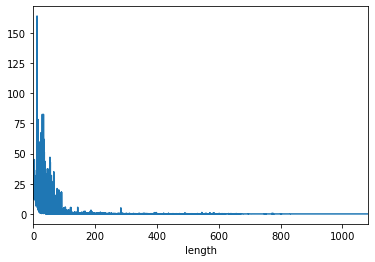

In [28]:
# Plot the trip volumes by distance to get an idea
# about the importance of probabilities on short relations
vp2017 = pd.read_csv('../input_static/vp2017_validation_normalised.csv')
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.set_index(['origin', 'destination'], drop=True).sum(axis=1).reset_index()
vp2017['v'] = vp2017[0] * 1000
merged = vp2017.merge(car.car_los[['origin', 'destination', 'length']],
                      on=['origin', 'destination'], how='inner')
merged['length'] = merged['length'] / 1000
merged.sort_values('length').set_index('length')['v'].plot()

In [29]:
# Which route types are accessible at the high-volume connections?
connections = pd.DataFrame(index=sm.los['route_type'].unique())
for head in [1, 10, 100, 1000, 10000, 100000]:
    connections[str(head)] = sm.los.loc[
        (sm.los['origin'].isin(list(merged.sort_values('v').tail(head)['origin']))) &
        (sm.los['destination'].isin(list(merged.sort_values('v').tail(head)['destination'])))
    ].groupby('route_type')['time'].count()
connections

,1,10,100,1000,10000,100000
coach,NaN,184,11425,240918,308119,308119
rail_short_distance,NaN,120,8592,266916,353861,353861
rail_long_distance,NaN,223,14810,350449,467323,467323
bus,NaN,8,306,7696,9932,9932
air,NaN,63,8462,199783,250134,250134
walk,1.0,6,44,220,228,228
car,1.0,72,4830,115940,154842,154842


<AxesSubplot:>

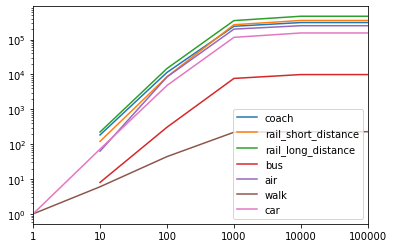

In [32]:
connections.T.plot(logy=True)

In [31]:
merged.sort_values('v').tail(10)

,origin,destination,0,v,length
69741,DE111,DE115,0.067162,67.162336,24.218
71310,DE115,DE111,0.067162,67.162336,24.082
32304,DEA27,DEA23,0.075163,75.163412,31.086
30735,DEA23,DEA27,0.075163,75.163412,31.382
77615,DE128,DE125,0.078357,78.357186,13.809
76438,DE125,DE128,0.078357,78.357186,14.029
69739,DE111,DE113,0.082482,82.482015,32.769
70524,DE113,DE111,0.082482,82.482015,29.011
93363,DE21H,DE212,0.163718,163.717916,12.226
87482,DE212,DE21H,0.163718,163.717916,11.861
